# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [32]:
import os
import PIL
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize as resz
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

unique:  [0. 1. 2. 3.]
max:  3.0


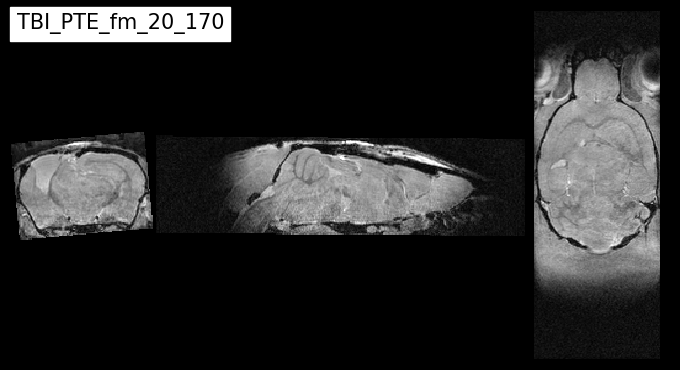

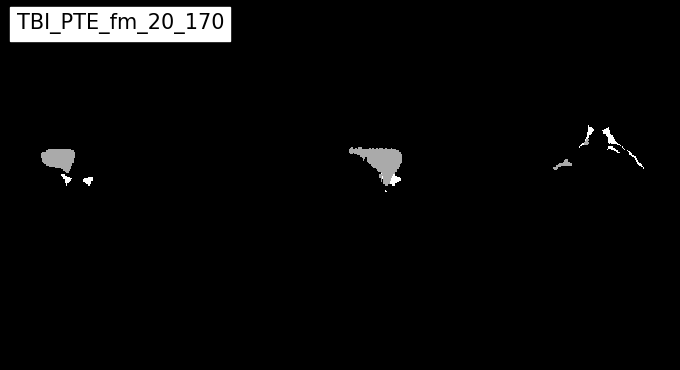

In [33]:
from utils.nifti import load_nifti
path = '../data_fix/fixed/'
case = 'TBI_PTE_fm_20_170'

# load nifti
nii_img, nii_data = load_nifti(os.path.join(path, case, 'Anat', case + '_N4.nii.gz'))

# plot nifti
nlplt.plot_anat(nii_img, title=case, display_mode='ortho', dim=-1, draw_cross=False, annotate=False, black_bg=True)

# load mask
mask_img, mask_data = load_nifti(os.path.join(path, case, 'Anat', case + '_lesion_mask.nii.gz'))

# plot nifti
nlplt.plot_anat(mask_img, title=case, display_mode='ortho', dim=-1, draw_cross=False, annotate=False, black_bg=True)

# print unique values in mask
print('unique: ', np.unique(mask_data))
print('max: ', np.max(mask_data))

unique:  [0. 1. 2. 3.]
max:  3.0
Input Orientation: IPL


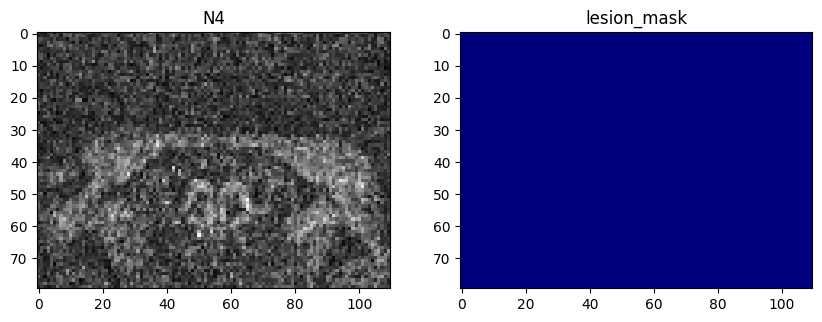

In [34]:
from utils.visualization import plot_data, plot_data_axis
from utils.loader import load_data
import SimpleITK as sitk

# Modalities
modalities = ['N4', 'lesion_mask']
layer=30
path = '../data_fix/fixed/'
for dir in os.listdir(path)[:1]:
    case = dir
    # Plot data
    images, data, file_paths = load_data(dir, path, modalities)
    print('unique: ', np.unique(data['lesion_mask']))
    # plot only label equal to 1
    # data['lesion_mask'][data['lesion_mask'] != 2] = 0
    # print max
    print('max: ', np.max(data['lesion_mask']))

    img1 = sitk.ReadImage(file_paths['lesion_mask'])
    input1_orientation = sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img1.GetDirection())
    print(f"Input Orientation: {input1_orientation}")

    plot_data_axis(data, layer, axis=1)

Input Orientation: RIA


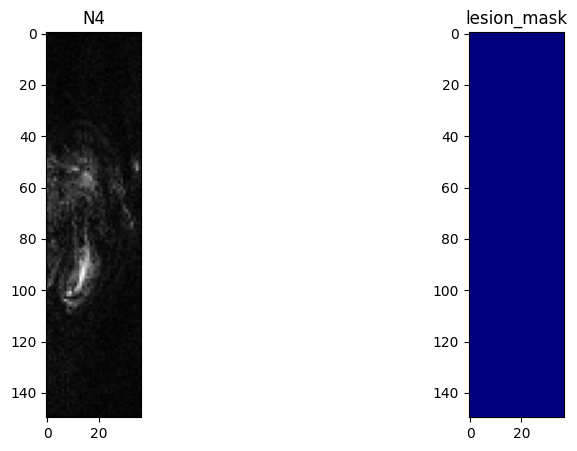

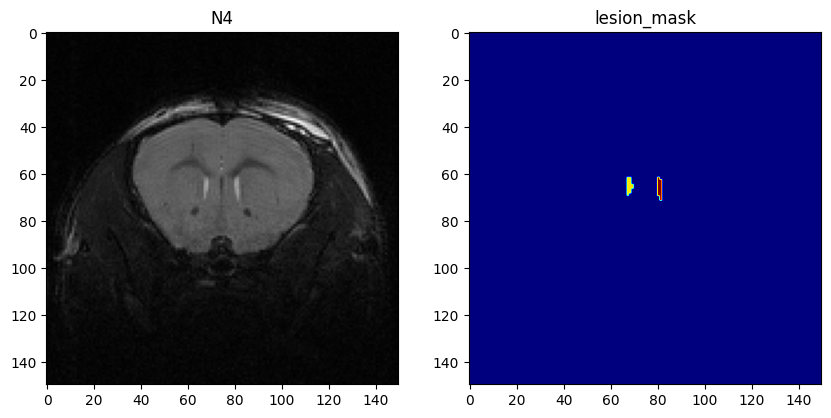

In [35]:
# TEMPLATE
modalities = ['N4', 'lesion_mask']
layer=25
path = '../dataset/'
case = 'TBI_fm_19_58'
# Plot data
template_img, template_data, template_path = load_data(case, path, modalities)
img1 = sitk.ReadImage(template_path['lesion_mask'])
target_orientation = sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img1.GetDirection())
print(f"Input Orientation: {target_orientation}")
plot_data_axis(template_data, layer, axis=1) #same as above
# They are oriented differently
plot_data_axis(template_data, layer, axis=2, rotation=-1) #correct

Target Orientation Codes: ('R', 'I', 'A')
Target Orientation Codes: ('R', 'I', 'A')


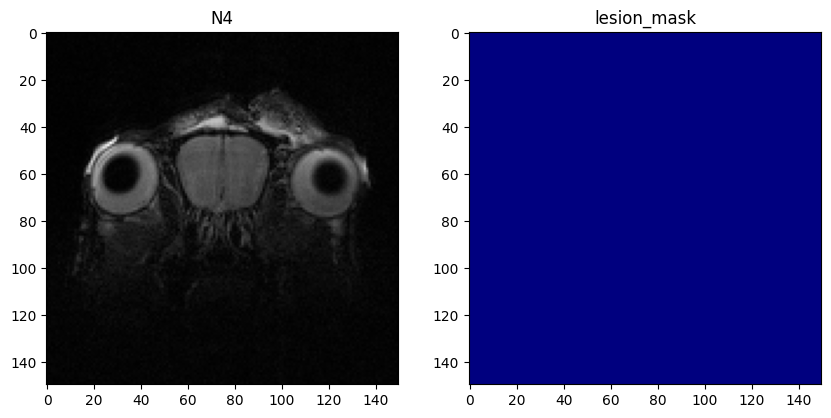

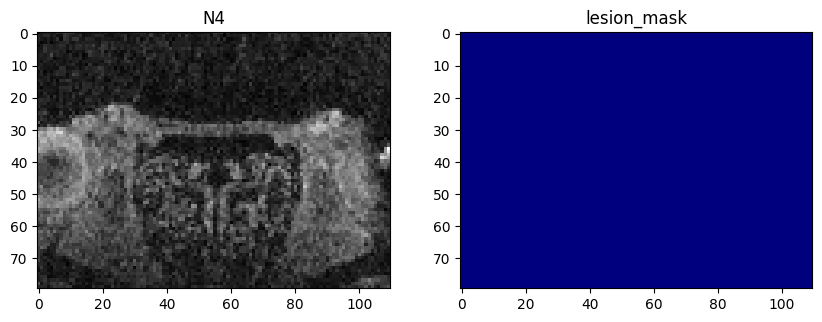

In [36]:
from nibabel.orientations import ornt_transform
from nibabel.orientations import axcodes2ornt

# Modalities
from utils.vedo import plot_two_volumes

modalities = ['N4', 'lesion_mask']
layer=30
path = '../data_fix/fixed/'
for dir in os.listdir(path)[:1]:
    case = dir
    # Plot data
    images, data, file_paths = load_data(dir, path, modalities)

    for modality in modalities:
        orig_ornt = nib.io_orientation(images[modality].affine)
        templ_ort = nib.io_orientation(template_img[modality].affine)

        targ_ornt_codes = nib.orientations.ornt2axcodes(templ_ort)
        print(f"Target Orientation Codes: {targ_ornt_codes}")

        targ_ornt = axcodes2ornt(targ_ornt_codes)
        transform = ornt_transform(orig_ornt, targ_ornt)

        img_orient = images[modality].as_reoriented(transform)
        data[modality] = img_orient.get_fdata()
        images[modality] = img_orient


    plot_data_axis(template_data, 35, axis=2, rotation=-1)
    plot_data_axis(data, 260, axis=2, rotation=-1)


    plot_two_volumes(data['N4'], template_data['N4'], spc1=[1,1,1], spc2=[1,1,3])

In [37]:
from nibabel.processing import *
from nibabel.orientations import *
from utils.vedo import plot_two_volumes

def copy_orientation(_from, _to):
    '''
    Copy orientation from source nib image to target nib image, without changing the target shape
    '''
    old_ornt = nib.io_orientation(_to.affine)
    copied_ort = nib.io_orientation(_from.affine)

    copied_codes = nib.orientations.ornt2axcodes(copied_ort)

    new_ornt = axcodes2ornt(copied_codes)
    transform = ornt_transform(old_ornt, new_ornt)

    _to = _to.as_reoriented(transform)

    return _to


def align_data(_from, _to, modalities, path, case, save=False, overwrite=False):
    '''
    Align data from source nib image to target nib image, without changing the target shape
    '''
    new_dict = {}
    for modality in modalities:
        _to[modality] = copy_orientation(_from[modality], _to[modality])
        new_dict[modality] = _to[modality].get_fdata()
        if save:
            # copy header from source to target
            _export = nib.Nifti1Image(new_dict[modality], _to[modality].affine, _to[modality].header, dtype=np.float64)
            if overwrite:
                nib.save(_export, os.path.join(path, case + '_' + modality + '.nii.gz'))
            else:
                nib.save(_export, os.path.join(path, case + '_' + modality + '_reo.nii.gz'))
                    
    # return dictionary of nib images
    return new_dict

path = '../data_fix/fixed/'
for dir in os.listdir(path):
    case = dir
    img, _, _ = load_data(dir, path, modalities)
    case_path = os.path.join(path, case, 'Anat')
    modalities = ['N4', 'lesion_mask']

    reoriented_nib = align_data(template_img, img, modalities, case_path, case, save=True, overwrite=True)
    print('unique: ', np.unique(reoriented_nib['lesion_mask']))
    # plot_data_axis(template_data, 35, axis=2, rotation=-1)
    # plot_data_axis(reoriented_nib, 260, axis=2, rotation=-1)
    # plot_two_volumes(reoriented_nib['N4'], template_data['N4'], spc2=[1,1,3])
    


unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
unique:  [0. 1. 2. 3.]
